Energy Data

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from common.utils import load_data

In [16]:
data_dir = 'C:\\Users\\Bam\\Desktop\\Disertatie\\halfhourly_dataset'
energy = load_data(data_dir)[['load']]
energy.tail()

,load
2014-02-27 22:00:00,0.416
2014-02-27 22:30:00,1.35
2014-02-27 23:00:00,1.247
2014-02-27 23:30:00,1.2180001
2014-02-28 00:00:00,1.387


Reduce dataframe to a month worth of data

In [17]:
start_date = '2013-08-01 00:00:00'
end_date = '2013-09-01 00:00:00'

energy = energy.loc[start_date:end_date]
energy.head()

,load
2013-08-01 00:00:00,0.154
2013-08-01 00:30:00,0.139
2013-08-01 01:00:00,0.104
2013-08-01 01:30:00,0.124
2013-08-01 02:00:00,0.104


The train / test split data ratio is 80% / 20%

In [18]:
train_start_date = '2013-08-01 00:00:00'
test_start_date = '2013-08-25 19:00:00'

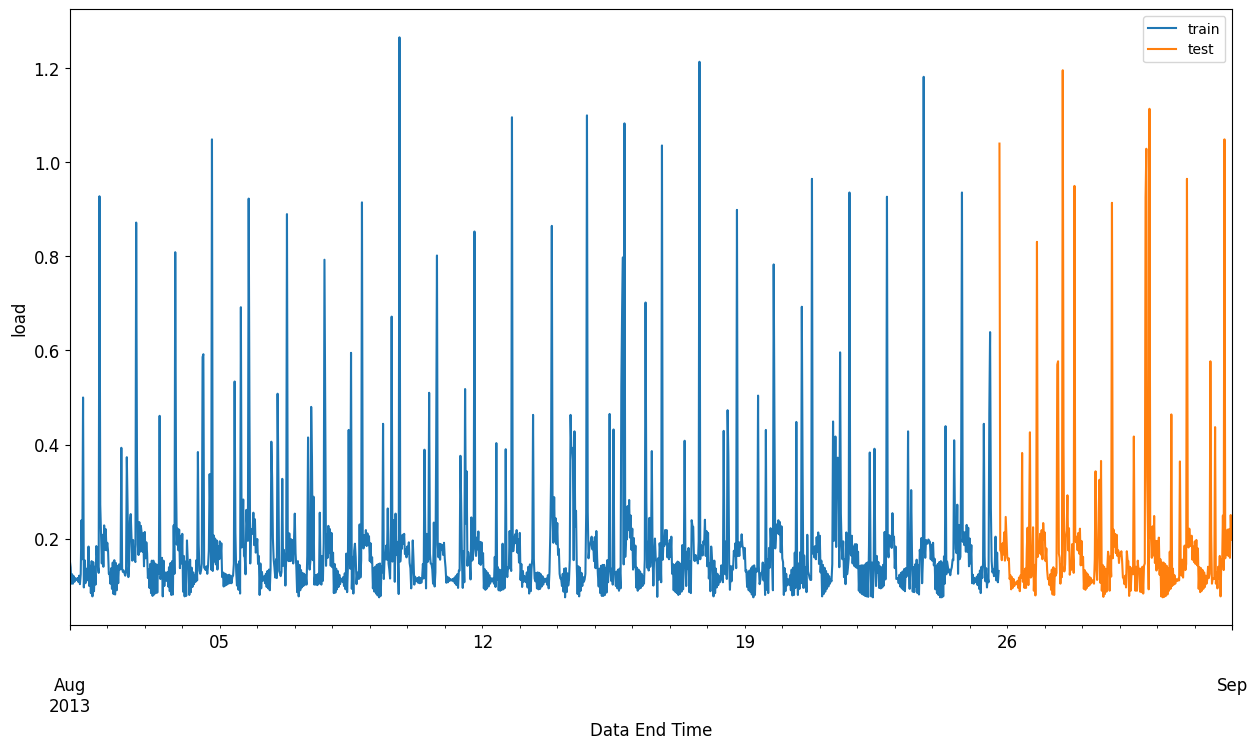

In [19]:
energy['load'] = pd.to_numeric(energy['load'])
energy[energy.index < test_start_date][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_date:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('Data End Time', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Load weather data from different source into Pandas Dataframe

In [20]:
weather = pd.read_csv('C:\\Users\\Bam\\Desktop\\Disertatie\\london_weather.csv')

weather['date'] = pd.to_datetime(weather['date'], format='%Y-%m-%d %H:%M')

weather.tail(2900)

,date,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point
0,2013-08-01 00:00:00,1.7,1012,15.8,100.00,3.1,15.8
1,2013-08-01 00:30:00,1.6,1012,15.6,100.00,3.0,15.6
2,2013-08-01 01:00:00,1.5,1012,15.4,100.00,3.0,15.4
3,2013-08-01 01:30:00,1.5,1012,15.3,100.00,3.0,15.3
4,2013-08-01 02:00:00,1.5,1011,15.1,100.00,3.0,15.1
...,...,...,...,...,...,...,...
1484,2013-08-31 22:00:00,2.4,1027,11.5,81.93,1.6,8.5
1485,2013-08-31 22:30:00,2.3,1027,11.3,83.02,1.5,8.5
1486,2013-08-31 23:00:00,2.2,1027,11.0,84.37,1.5,8.5
1487,2013-08-31 23:30:00,2.0,1027,10.6,86.64,1.5,8.5


Energy and Weather dataset integration and interpolation.

In [21]:
weather.set_index('date', inplace=True)

weather_energy = energy.merge(weather, how='left', left_index=True, right_index=True)

weather_energy.interpolate(method='time', inplace=True)

weather_energy.head()

,load,wind_speed,pressure,temperature,relative_humidity,precipitable_water,dew_point
2013-08-01 00:00:00,0.154,1.7,1012,15.8,100.0,3.1,15.8
2013-08-01 00:30:00,0.139,1.6,1012,15.6,100.0,3.0,15.6
2013-08-01 01:00:00,0.104,1.5,1012,15.4,100.0,3.0,15.4
2013-08-01 01:30:00,0.124,1.5,1012,15.3,100.0,3.0,15.3
2013-08-01 02:00:00,0.104,1.5,1011,15.1,100.0,3.0,15.1


Feature Engineering

In [22]:
energy['load'] = pd.to_numeric(energy['load'], errors='coerce')
peak_threshold = energy['load'].quantile(0.90)  # Adjust the quantile as needed

bank_holidays = pd.read_csv('C:\\Users\\Bam\\Desktop\\Disertatie\\uk_bank_holidays.csv')
bank_holidays['Bank holidays'] = pd.to_datetime(bank_holidays['Bank holidays']).dt.date
bank_holiday_dates = set(bank_holidays['Bank holidays'])

weather_energy['temp_humidity_interaction'] = weather_energy['temperature'] * weather_energy['relative_humidity']

weather_energy['hour'] = energy.index.hour
weather_energy['day_of_week'] = energy.index.dayofweek
weather_energy['month'] = energy.index.month
weather_energy['is_weekend'] = energy.index.dayofweek >= 5
weather_energy['is_peak_hour'] = np.where(energy['load'] >= peak_threshold, 1, 0)
weather_energy['is_bank_holiday'] = pd.Series(weather_energy.index.date).isin(bank_holiday_dates).values

# Lag features
weather_energy['previous_load'] = energy['load'].shift(1).fillna(0)
weather_energy['previous_is_peak_hour'] = weather_energy['is_peak_hour'].shift(1).fillna(0)
weather_energy['lag_3'] = energy['load'].shift(3).fillna(0)
weather_energy['rolling_mean_3'] = energy['load'].rolling(window=3).mean().fillna(0)
weather_energy['rolling_mean_2'] = energy['load'].rolling(window=2).mean().fillna(0)

Splitting the data into training and testing sets

In [23]:
train = weather_energy[(weather_energy.index >= train_start_date) & (weather_energy.index <= test_start_date)]
test = weather_energy[(weather_energy.index >= test_start_date)]

X_train = train.drop(columns=['load'])
y_train = train['load']

X_test = test.drop(columns=['load'])
y_test = test['load']

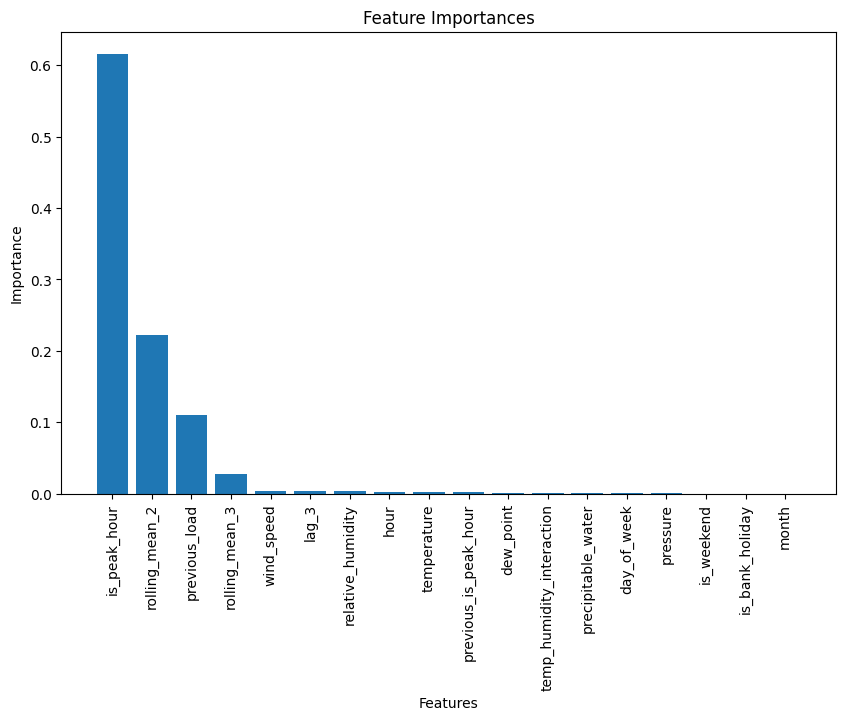

In [24]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Assuming 'X' contains your feature matrix and 'y' contains your target variable
# X should be your weather_energy dataframe without the target variable
# y should be the target variable you are trying to predict

# Initialize Random Forest Regressor
rf = RandomForestRegressor()

# Fit the model
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), feature_names[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


Building, Training and Using the Model

In [25]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(score_func=f_regression)),
    ('svr', SVR())
])

# Define the parameter grid
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],  # Different scalers to try
    'selector__k': [1, 3, 6],  # Number of features to select
    'svr__kernel': ['linear', 'rbf', 'poly'],
    'svr__C': [0.1, 0.5, 1, 10],
    'svr__gamma': ['scale', 'auto'],
    'svr__epsilon': [0.01, 0.1, 0.5, 0.9]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Predict energy consumption on the test set
y_pred = best_model.predict(X_test)

In [26]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Cross-validated MSE: {-np.mean(cv_scores)}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print('MAPE for testing data: ', mape * 100, '%')

Cross-validated MSE: 4.52556917869702e-05
Mean Squared Error: 2.1844292720145313e-05
R-squared: 0.99924506881535
MAPE for testing data:  2.601343562729475 %


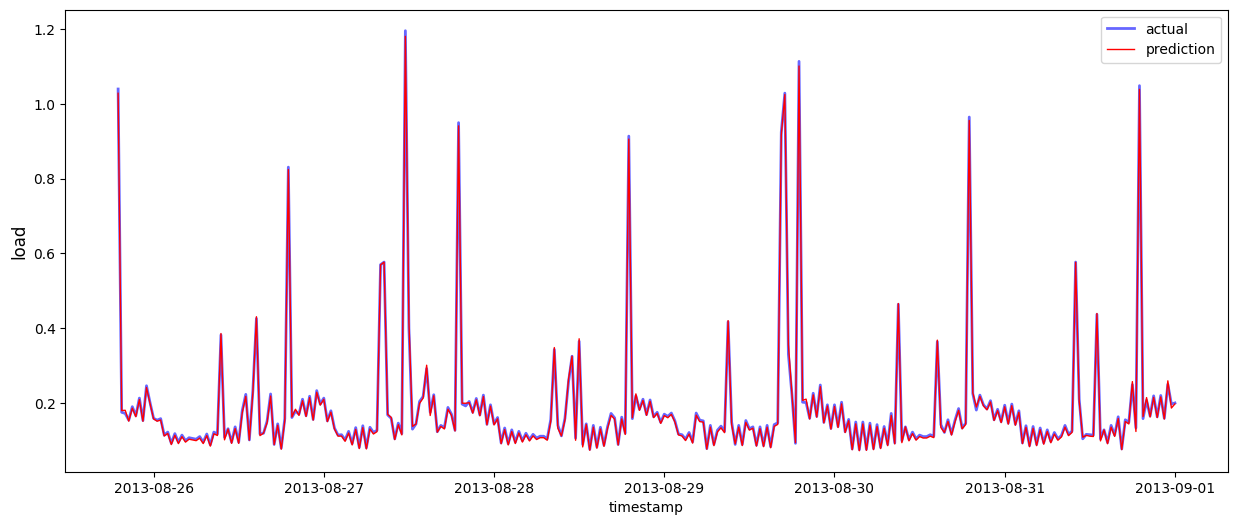

In [27]:
plt.figure(figsize=(15,6))
plt.plot(test.index, y_test, color = 'blue', linewidth=2.0, alpha = 0.6)
plt.plot(test.index, y_pred, color = 'red', linewidth=1.0)
plt.legend(['actual','prediction'])
plt.xlabel('timestamp')
plt.ylabel('load', fontsize=12)
plt.show()